In [1]:
# Run this cell to see if fmm is installed properly.
# If it fails, you won't be able to run the cells using fmm

! fmm

[info][fmm_app_config.cpp:49 ] Start reading FMM configuration from arguments
fmm argument lists:
--ubodt (required) <string>: Ubodt file name
--network (required) <string>: Network file name
--network_id (optional) <string>: Network id name (id)
--source (optional) <string>: Network source name (source)
--target (optional) <string>: Network target name (target)
--gps (required) <string>: GPS file name
--gps_id (optional) <string>: GPS id name (id)
--gps_x (optional) <string>: GPS x name (x)
--gps_y (optional) <string>: GPS y name (y)
--gps_timestamp (optional) <string>: GPS timestamp name (timestamp)
--gps_geom (optional) <string>: GPS geometry name (geom)
--gps_point (optional): if specified read input data as gps point, otherwise (default) read input data as trajectory
--output (required) <string>: Output file name
--output_fields (optional) <string>: Output fields
  opath,cpath,tpath,mgeom,pgeom,
  offset,error,spdist,tp,ep,length,duration,speed,all
-k/--candidates (optional) <int>

## A New Approach to Map Matching Algorithms

### A project sponsered by Mitsubishi in Sendai, Japan

Team: Seiya Omura, Tomoya Akamatsu, Katelynn Huneycutt, Gabriel Gress


In [2]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np

%matplotlib inline
ox.__version__

/home/gjgress/.local/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


'1.2.1'

First, we download from OSM a street map for a section of Sendai, JP-- particularly, the area around Tohoku University. However, OSMnx by default does not track directionality of roads-- this is an important factor when map matching, so we use a script created by cyang-kth for their fmm program which saves this information.

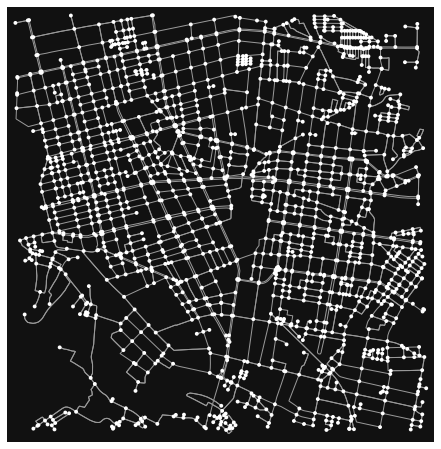

/tmp/ipykernel_8269/955767582.py:20: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


In [28]:
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')
    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)


S = ox.graph_from_address("Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",dist=1750, network_type='drive')
fig, ax = ox.plot_graph(S)

save_graph_shapefile_directional(S, filepath='Tohoku')

The default format that OSMnx models networks is as `MultiDiGraph` objects. In order to manipulate these objects mathematically, we will need to convert this to `GeoDataFrame`. 

In [29]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(S)
gdf_nodes.head()

,y,x,highway,street_count,geometry
osmid,,,,,
244879417,38.266126,140.871677,traffic_signals,4,POINT (140.87168 38.26613)
244879418,38.260102,140.875203,traffic_signals,4,POINT (140.87520 38.26010)
301789611,38.256070,140.873493,traffic_signals,4,POINT (140.87349 38.25607)
301789618,38.255104,140.875946,NaN,4,POINT (140.87595 38.25510)
301789634,38.252816,140.879493,traffic_signals,4,POINT (140.87949 38.25282)


In [30]:
gdf_edges.head()

osmid  oneway     ref   name   highway maxspeed  \
u         v          key                                                        
244879417 1201390811 0    218028552    True      45   定禅寺通     trunk       60   
          4025385190 0    461330966    True  286;48  東二番丁通     trunk       60   
244879418 1201358483 0     30999231    True     NaN    青葉通  tertiary      NaN   
          1256397159 0    899682371    True     286  東二番丁通     trunk       60   
301789611 1837893264 0    837910375   False     NaN    NaN  tertiary      NaN   

                         reversed  length  \
u         v          key                    
244879417 1201390811 0      False  17.586   
          4025385190 0      False  66.732   
244879418 1201358483 0      False  15.304   
          1256397159 0      False  94.102   
301789611 1837893264 0       True  11.727   

                                                                   geometry  \
u         v          key                                                      
244879417 1201390811 0    LINESTRING (140.87168 38.26613, 140.87148 38.2...   
          4025385190 0    LINESTRING (140.87168 38.26613, 140.87178 38.2...   
244879418 1201358483 0    LINESTRING (140.87520 38.26010, 140.87503 38.2...   
          1256397159 0    LINESTRING (140.87520 38.26010, 140.87564 38.2...   
301789611 1837893264 0    LINESTRING (140.87349 38.25607, 140.87347 38.2...   

                         lanes bridge tunnel  
u         v          key                      
244879417 1201390811 0     NaN    NaN    NaN  
          4025385190 0     NaN    NaN    NaN  
244879418 1201358483 0       4    NaN    NaN  
          1256397159 0     NaN    NaN    NaN  
301789611 1837893264 0     NaN    NaN    NaN

Now let's look at the GPS data from a day walking around Sendai.

In [31]:
import geopandas as gpd
# Enable KML driver
gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"

# Read file from KML
fp = "history-2022-06-21.kml"
tripdata = gpd.read_file(fp, driver='KML')

<AxesSubplot:>

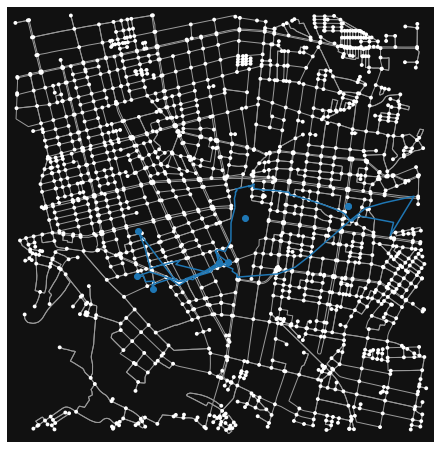

In [32]:
fig, ax = ox.plot_graph(S,show=False, close=False)
tripdata.plot(ax=ax)

Now we will run this information through FMM as a baseline. To do this we will first need to convert our GeoDataFrame to a Shapefile.

In [33]:
# Simplify tripdata to only LineStrings
td = tripdata[tripdata.geom_type == 'LineString'].geometry

# Write to Shapefile (just make a copy)
outfp = "temp/history-2022-06-21.shp"
td.to_file(outfp)

Because FMM uses the same network datatype as us, we do not need to make any modifications to our network. Now we are ready to use FMM.

In [34]:
from fmm import Network,NetworkGraph,FastMapMatch,UBODTGenAlgorithm,UBODT,FastMapMatchConfig,GPSConfig,ResultConfig

In [35]:
network = Network("Tohoku/edges.shp","fid","u","v")
print ("Nodes {} edges {}".format(network.get_node_count(),network.get_edge_count()))
graph = NetworkGraph(network)

Nodes 1691 edges 3949
[2022-06-23 17:21:51.287] [info] [network.cpp:72] Read network from file Tohoku/edges.shp
[2022-06-23 17:21:51.308] [info] [network.cpp:170] Number of edges 3949 nodes 1691
[2022-06-23 17:21:51.308] [info] [network.cpp:171] Field index: id 14 source 0 target 1
[2022-06-23 17:21:51.310] [info] [network.cpp:174] Read network done.
[2022-06-23 17:21:51.311] [info] [network_graph.cpp:17] Construct graph from network edges start
[2022-06-23 17:21:51.311] [info] [network_graph.cpp:30] Graph nodes 1691 edges 3949
[2022-06-23 17:21:51.311] [info] [network_graph.cpp:31] Construct graph from network edges end


In [36]:
### Precompute an UBODT table

# Can be skipped if you already generated an ubodt file
ubodt_gen = UBODTGenAlgorithm(network,graph)
status = ubodt_gen.generate_ubodt("temp/ubodt.txt", 0.02, binary=False, use_omp=True)
print(status)

Status: success
Time takes 0.941 seconds
[2022-06-23 17:21:51.442] [info] [ubodt_gen_algorithm.cpp:76] Start to generate UBODT with delta 0.02
[2022-06-23 17:21:51.442] [info] [ubodt_gen_algorithm.cpp:77] Output format csv
[2022-06-23 17:21:51.538] [info] [ubodt_gen_algorithm.cpp:105] Progress 169 / 1691
[2022-06-23 17:21:51.632] [info] [ubodt_gen_algorithm.cpp:105] Progress 338 / 1691
[2022-06-23 17:21:51.737] [info] [ubodt_gen_algorithm.cpp:105] Progress 507 / 1691
[2022-06-23 17:21:51.828] [info] [ubodt_gen_algorithm.cpp:105] Progress 676 / 1691
[2022-06-23 17:21:51.922] [info] [ubodt_gen_algorithm.cpp:105] Progress 845 / 1691
[2022-06-23 17:21:52.008] [info] [ubodt_gen_algorithm.cpp:105] Progress 1014 / 1691
[2022-06-23 17:21:52.089] [info] [ubodt_gen_algorithm.cpp:105] Progress 1183 / 1691
[2022-06-23 17:21:52.173] [info] [ubodt_gen_algorithm.cpp:105] Progress 1352 / 1691
[2022-06-23 17:21:52.264] [info] [ubodt_gen_algorithm.cpp:105] Progress 1521 / 1691



In [37]:
### Read UBODT

ubodt = UBODT.read_ubodt_csv("temp/ubodt.txt")

[2022-06-23 17:21:52.404] [info] [ubodt.cpp:208] Reading UBODT file (CSV format) from temp/ubodt.txt
[2022-06-23 17:21:52.963] [info] [ubodt.cpp:236] Read rows 1000000
[2022-06-23 17:21:53.063] [info] [ubodt.cpp:243] Finish reading UBODT with rows 1188142


In [38]:
### Create FMM model
model = FastMapMatch(network,graph,ubodt)

### Define map matching configurations

k = 8
radius = 0.003
gps_error = 0.0005
fmm_config = FastMapMatchConfig(k,radius,gps_error)

In [54]:
input_config = GPSConfig()
input_config.file = "temp/history-2022-06-21.shp"
input_config.id = "FID"

result_config = ResultConfig()
result_config.file = "temp/mr.csv"
result_config.output_config.write_opath = True
print(result_config.to_string())

result = model.match_gps_file(input_config, result_config, fmm_config)

Result file : temp/mr.csv
Output fields: opath cpath mgeom 
[2022-06-23 17:33:56.537] [critical] [gps_config.cpp:118] GPS file temp/history-2022-06-21.shp not found
[2022-06-23 17:33:56.537] [warning] [result_config.cpp:221] Overwrite existing result file temp/mr.csv


<AxesSubplot:>

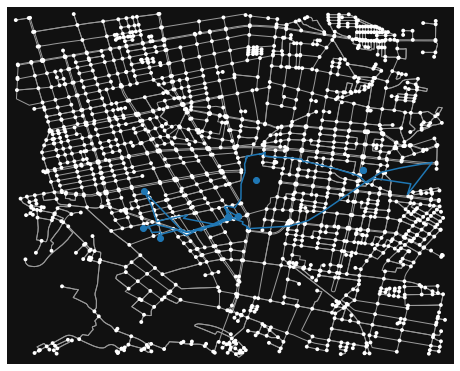

In [55]:
### Print map matching result


resultdf = gpd.read_file("temp/mr.csv")

fig, ax = ox.plot_graph(S,show=False, close=False)
tripdata.plot(ax=ax)
resultdf.plot(ax=ax)


In [67]:
resultdf

,id,opath,cpath,mgeom,geometry
0,5,"2831,2831,222,2637,2637,1574,1574","2831,222,2637,3538,1574","LINESTRING(140.8736778 38.2551673,140.8736007 ...",None
1,9,"325,325,2565,2568,2568,33,37,37,37","325,2565,2568,33,37","LINESTRING(140.8809997 38.2566672,140.880963 3...",None
2,6,"3538,3538,2964,2961,2961,2965,3443,3440,40,251...","3538,1575,163,2964,2961,2965,3443,3438,3440,25...","LINESTRING(140.8721267 38.2560657,140.8721267 ...",None
3,3,"269,269,268,2468,321,2568,2568,2568,33,33","269,268,2468,1679,321,2568,33","LINESTRING(140.881120814 38.2608957785,140.881...",None
4,8,"3080,3080,2961,2965,2965,2965,2965,3443,3438,3...","3080,3608,3613,121,123,1848,2476,1903,219,2961...","LINESTRING(140.872173061 38.2588792055,140.871...",None
5,0,"33,33,36,2566,2533,2533,2533,2533,2533,357,357...","33,36,2566,323,1725,2520,2528,2533,357,2521,36...","LINESTRING(140.88018889 38.2568937743,140.8803...",None
6,1,"3460,3460,532,429,427,427,372,1180,531,531","3460,532,3465,3466,514,832,864,426,429,427,406...","LINESTRING(140.893513625 38.2605300794,140.893...",None
7,7,"2516,2516,31,3445,3445,1551,2690,2690,2690,269...","2516,2519,31,38,1518,1551,3445,1551,3444,1807,...","LINESTRING(140.879630374 38.256566236,140.8797...",None
8,2,"3464,3461,530,1096,990,777,777,3561,3561,3561,...","3464,3461,530,1096,500,1074,1035,373,1060,369,...","LINESTRING(140.8934041 38.2602534,140.8931974 ...",None
9,4,"2516,2516,38,1519,1519,3439,8,2831,222,222","2516,2519,31,38,1519,2558,3441,3439,3055,8,283...","LINESTRING(140.879630374 38.256566236,140.8797...",None


In [60]:
tripdata

,Name,Description,geometry
0,Home In Japan (Hotel Green Mark),Hotel from 2022-06-20T08:40:34.791Z to 2022-06...,POINT Z (140.87990 38.25672 0.00000)
1,Cycling,Cycling from 2022-06-20T21:47:18.802Z to 2022-...,"LINESTRING Z (140.87990 38.25672 0.00000, 140...."
2,Tsutsujigaoka,from 2022-06-20T22:01:57.372Z to 2022-06-20T22...,POINT Z (140.89238 38.26100 0.00000)
3,Walking,Walking from 2022-06-20T22:12:51.831Z to 2022-...,"LINESTRING Z (140.89354 38.26051 0.00000, 140...."
4,Tsutsujigaoka,from 2022-06-20T22:28:11.978Z to 2022-06-20T22...,POINT Z (140.89238 38.26100 0.00000)
5,Cycling,Cycling from 2022-06-20T22:36:56.000Z to 2022-...,"LINESTRING Z (140.89337 38.26027 0.00000, 140...."
6,Sendai Station,Transit station from 2022-06-20T22:48:54.019Z ...,POINT Z (140.88244 38.26013 0.00000)
7,Walking,Walking from 2022-06-20T23:23:30.190Z to 2022-...,"LINESTRING Z (140.88147 38.26088 0.00000, 140...."
8,Home In Japan (Hotel Green Mark),Hotel from 2022-06-20T23:30:18.000Z to 2022-06...,POINT Z (140.87990 38.25672 0.00000)
9,Walking,Walking from 2022-06-21T00:13:57.704Z to 2022-...,"LINESTRING Z (140.87990 38.25672 0.00000, 140...."
